## Visualization of Mask RCNN prediction on groceries dataset
As I exported trained model with command ```jit.save(model, <model_name>)``` and it was running on GPU, so this to work You need to have GPU on your computer.

### How this evaluation works
This is just visualization of GT masks and predicted masks by model. In every run random image will be chosen from test set and GT masks and predicted masks will be shown. If You want to see another image, just run cell again.

### FIRST THING TO DO
1. Download model
2. Set paths to the model and to the dataset

In [40]:
import os
import random
import numpy as np
import cv2 as cv
import torch
import torchvision

from PIL import ImageColor
from matplotlib import pyplot as plt
from pycocotools.coco import COCO

In [41]:
def color_masks(img, masks, masks_color):
    for mask, color in zip(masks, masks_color):
        masked_img = np.where(mask, color, img).astype(np.uint8)
        img = cv.addWeighted(img, 0.5, masked_img, 0.4, 0)
    return img

In [42]:
def get_gt_mask(coco, image_id, img):
    ann_ids = coco.getAnnIds(imgIds=image_id)
    coco_annotation = coco.loadAnns(ann_ids)
    num_objs = len(coco_annotation)
    masks, masks_color = [], []
    for i in range(num_objs):
        masks.append(cv.cvtColor(coco.annToMask(coco_annotation[i]) * 255, cv.COLOR_GRAY2BGR))
        masks_color.append(coco_annotation[i]["color"])
    masks = np.stack(masks, axis=0)
    masks_color = [np.array(ImageColor.getcolor(color, "RGB")) for color in masks_color]
    img_with_gt_mask = color_masks(img, masks, masks_color)
    return img_with_gt_mask

In [43]:
def generate_random_colors(n):
    colors = []
    for _ in range(n):
        r = random.randint(50, 255)
        g = random.randint(50, 255)
        b = random.randint(50, 255)
        color = (r, g, b)
        colors.append(color)
    return np.array(colors)

In [44]:
def postprocess(prediction, img):
    masks = []
    for i in range(len(prediction[1][0]['masks'])):
        if prediction[1][0]['scores'][i] > 0.5:
            mask = prediction[1][0]['masks'][i, 0].mul(255).byte().cpu().numpy().reshape((img.shape[0], img.shape[1]))
            _, mask = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)
            masks.append(cv.cvtColor(mask, cv.COLOR_GRAY2BGR))
    masks = np.stack(masks, axis=0)
    masks_colors = generate_random_colors(len(masks))
    img_with_predicted_mask = color_masks(img, masks, masks_colors)
    return img_with_predicted_mask

In [45]:
@torch.inference_mode()
def get_predicted_masks(model_path, img):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    tensor_img = torchvision.transforms.ToTensor()(img).to(device)
    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    with torch.no_grad():
        prediction = model([tensor_img])
    img_predicted_mask = postprocess(prediction, img)
    return img_predicted_mask

In [46]:
model_path = "/home/maco/Documents/photoneo/maskrcnn-groceries/models/groceries_maskrcnn.pt"
root_image_dir = "/home/maco/Documents/photoneo/data/groceries/test"
test_coco_file = "/home/maco/Documents/photoneo/data/groceries/test/.exports/coco-1686932837.coco.json"

# read coco file
coco = COCO(test_coco_file)

# pick random image to evaluate model on
len_test_dataset = len(coco.imgs)
image_id = random.randint(0, len_test_dataset)
path = coco.loadImgs(image_id)[0]["file_name"]
img = cv.imread(os.path.join(root_image_dir, path))

gt_img_mask = get_gt_mask(coco, image_id, img)
pred_img_mask = get_predicted_masks(model_path, img)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


code/__torch__/torchvision/models/detection/mask_rcnn.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


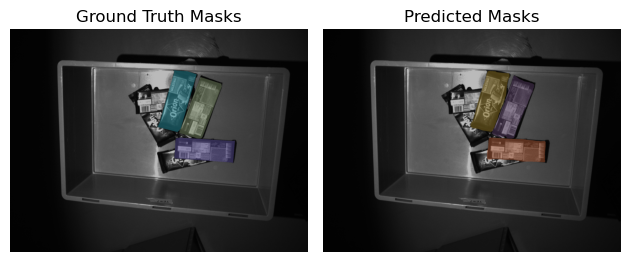

In [47]:
# Create a figure and subplot grid
fig, axs = plt.subplots(1, 2)

# Display images on subplots
axs[0].imshow(gt_img_mask)
axs[0].set_title('Ground Truth Masks')
axs[0].axis('off')

axs[1].imshow(pred_img_mask)
axs[1].set_title('Predicted Masks')
axs[1].axis('off')

# Adjust subplot spacing
plt.tight_layout()

# Show the figure
plt.show()